In [1]:
import csv
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.preprocessing import LabelEncoder, Imputer
from sklearn.metrics import auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint as sp_randint
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
import numpy as np
import itertools as it

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import os
os.chdir("/home/thibault/Documents/oilprediction_challenge/Code/functions")
import skmice

import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option("display.max_columns", 200)

PATH = "/home/thibault/Documents/oilprediction_challenge/"
PATH_DATA = PATH + "Data/"
PATH_RESULT = PATH + "Result/"

# 1 - LOAD DATA

In [2]:
Y = pd.read_csv(PATH_DATA + "Y_train.csv", sep=";")
X = pd.read_csv(PATH_DATA + "Train.csv", sep=";")
final_test = pd.read_csv(PATH_DATA + "Test.csv", sep=";")

X_full = pd.concat([X, final_test])

# 2 - Data transformation

###### Data depending on month

In [3]:
nb_increase_by_month = X.merge(Y, how="left", on="ID").groupby("month").Target.sum().reset_index()

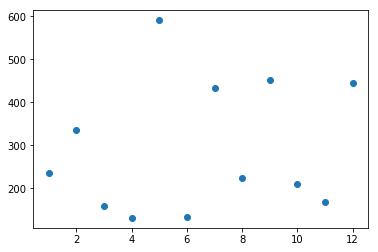

In [4]:
plt.scatter(nb_increase_by_month.month, nb_increase_by_month.Target)

###### Missing value

In [5]:
n_0_in_lines = X.apply(lambda x: pd.isnull(x).sum(), axis=1)

# Keep only line with less than n missing value
X = X.loc[n_0_in_lines <= 20, :]
Y = Y.loc[n_0_in_lines <= 20, :]

X_full = pd.concat([X, final_test])

###### Outliers

No need for outliers handling using random Forest but we will look at it anyways

# Create Variable

We Create binary varialbe => note realli working

In [6]:
column_to_transform = list(X_full.columns[3:])

###### If positiv

In [7]:
def binary_if_positive(x):
    if x > 0:
        result = 1
    else:
        result = 0
    return(result)

for var in column_to_transform:
    X_full.loc[:, "binary_if_positive_" + var] =\
        X_full.loc[:, var].map(lambda x: binary_if_positive(x))

###### Create is 0

In [8]:
def binary_if_0(x):
    if x == 0:
        result = 1
    else:
        result = 0
    return(result)

# Get columns with lot of 0
columns_with_0 =\
    [ x for x in column_to_transform if ("_diffClosing stocks(kmt)" in x or "_diffExports(kmt)" in x
                                        or "_diffImports(kmt)" in x or "_diffRefinery intake(kmt" in x) ]

for var in columns_with_0:
    X_full.loc[:, "binary_if_0_" + var] =\
        X_full.loc[:, var].map(lambda x: binary_if_0(x))
        
binary_0_columns =\
    pd.Series(X_full.columns ).loc[pd.Series(X_full.columns ).map(lambda x: "binary_if_0_" in x)]

###### Percent of 0 by columns, country and month

In [ ]:
for var in columns_with_0:
    if var == columns_with_0[0]:
        grouped_0_values =\
            X_full.loc[:, [var] + ["country", "month"]].groupby(["country", "month"])[var].\
                apply(lambda x: (x ==0).mean()).reset_index()
    else:
        temp_grouped_0_values =\
            X_full.loc[:, [var] + ["country", "month"]].groupby(["country", "month"])[var].\
                apply(lambda x: (x ==0).mean()).reset_index()
        grouped_0_values = grouped_0_values.merge(temp_grouped_0_values, how="left",
                                                 on=["country", "month"])
        
grouped_0_values.columns = list(grouped_0_values.columns[:2]) +\
                               ["percent_0_" + x for x in list(grouped_0_values.columns[2:])]
    
X_full = X_full.merge(grouped_0_values, how="left", on=["country", "month"])

###### Binary if 0

In [ ]:
def binary_if_null(x):
    if pd.isnull(x):
        result = 1
    else:
        result = 0
    return(result)

for var in column_to_transform:
    X_full.loc[:, "binary_if_null_" + var] =\
        X_full.loc[:, var].map(lambda x: binary_if_null(x))

###### Aggregate by month and country

In [ ]:
def percentile(n):
    def percentile_(x):
        return np.nanpercentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [ ]:
grouped_values =\
    X_full.loc[:, column_to_transform + ["country", "month"]].replace(0, np.nan).groupby(["country", "month"]).\
        agg([np.nansum, np.nanmean, np.nanstd, np.min, 
             np.max, np.nanmedian, percentile(75),
             percentile(25), percentile(10), percentile(90)]).reset_index()
    
grouped_values.columns = [' '.join(col).strip() for col in grouped_values.columns.values]

X_full = X_full.merge(grouped_values, how="left", on=["country", "month"])

###### Diff between export and import

Variation of commercial balance for oil

In [ ]:
column_import =\
    [ x for x in column_to_transform if ("_diffImports(kmt)" in x) ]
    
column_export =\
    [ x for x in column_to_transform if ("_diffExports(kmt)" in x) ]
    
columns_import_export = [(a,b) for a,b in zip(column_import, column_export)]

for (a, b) in columns_import_export:
    X_full.loc[:, a + b] = X_full.loc[:, a] - X_full.loc[:, b]

###### Diff_import_export + closing stock

Variation of commercial balance + variation of stock

In [ ]:
columns_closing_stocks =\
    [ x for x in column_to_transform if ("_diffClosing stocks(kmt)" in x) ]
    
columns_import_export_closing_stock = [(a, b, c) for (a, b, c) in zip(column_import, column_export, columns_closing_stocks)]


In [ ]:
for (a, b, c) in columns_import_export_closing_stock:
    X_full.loc[:, a + b + c] = X_full.loc[:, c] + (X_full.loc[:, a] - X_full.loc[:, b])

###### Variation in country vs variation in all countries

In [ ]:
column_to_transform_without_sum = [x for x in column_to_transform if ("Sum" not in x and "WTI" not in x)]


In [ ]:
for var in column_to_transform_without_sum:
    X_full.loc[:, var + "_diff_with_global"] =\
        X_full.loc[:, var] / X_full.loc[:, var.split("diff")[0] + "diffSum" + var.split("diff")[1]]

In [ ]:
X_full.loc[:, ["1_diffExports(kmt)", "countries"]].head()

###### Countries with no variation in import and export

In [ ]:
countries_with_no_variation_in_import =\
    X_full.loc[:, ["1_diffImports(kmt)", "country"]].groupby("country")["1_diffImports(kmt)"].\
        apply(lambda x: (x == 0).mean()).reset_index()

In [ ]:
countries_with_no_variation_in_export =\
    X_full.loc[:, ["1_diffExports(kmt)", "country"]].groupby("country")["1_diffExports(kmt)"].\
        apply(lambda x: (x == 0).mean()).reset_index()

In [ ]:
countries_with_no_variation_in_import_export =\
    countries_with_no_variation_in_import.merge(countries_with_no_variation_in_export, how="left",
                                               on="country")
    
countries_with_no_variation_in_import_export.loc[:, "no_import_variation"] =\
    countries_with_no_variation_in_import.loc[:, "1_diffImports(kmt)"] == 1

countries_with_no_variation_in_import_export.loc[:, "no_export_variation"] =\
    countries_with_no_variation_in_export.loc[:, "1_diffExports(kmt)"] == 1
    
countries_with_no_variation_in_import_export.loc[:, "no_export_nor_import_variation"] =\
    countries_with_no_variation_in_import_export.no_import_variation &\
    countries_with_no_variation_in_import_export.no_export_variation
    
X_full =\
    X_full.merge(countries_with_no_variation_in_import_export, how="left",
                on="country")

###### Compute relative value by countries

In [ ]:
# Dataframe as list
def data_frame_as_Series(dataframe):
    return(pd.Series(list(it.chain(*dataframe.values))))

col_names_without_month = set([x.split("_")[1] for x in column_to_transform])

# By countries
relative_value = pd.DataFrame()
for var in list(col_names_without_month):
    relative_value_by_countries = pd.DataFrame()
    for localisation in set(X_full.country):
        all_months_columns = [str(j) + "_" + var for j in range(1, 13)]
        median_value = data_frame_as_Series(X_full.loc[X_full.country == localisation, all_months_columns]).\
            dropna().sum()
        relative_value_by_countries_columns =\
            X_full.loc[X_full.country == localisation, all_months_columns] / median_value
        # replace inf
        relative_value_by_countries_columns =\
            relative_value_by_countries_columns.replace([np.inf, -np.inf], np.nan)
        relative_value_by_countries_columns.loc[:, "ID"] = X_full.loc[X_full.country == localisation, "ID"]
        if relative_value_by_countries.empty:
            relative_value_by_countries = relative_value_by_countries_columns
        else:
            relative_value_by_countries = pd.concat([relative_value_by_countries, 
                                                     relative_value_by_countries_columns],
                                                   axis=0)
    if relative_value.empty:
        relative_value = relative_value_by_countries
    else:
        relative_value = relative_value.merge(relative_value_by_countries, on="ID", how="left")


In [ ]:
def new_name_if_not_id(x, prefix_name=None):
    if x != "ID":
        new_name = prefix_name + x
    else:
        new_name = x
    return(new_name)

relative_value.columns = [new_name_if_not_id(x, "relative_by_countries_") for x in list(relative_value.columns)]

In [ ]:
X_full = X_full.merge(relative_value, how="left", on="ID")

###### Compute relative values by countries and month

In [ ]:
# Dataframe as list
def data_frame_as_Series(dataframe):
    return(pd.Series(list(it.chain(*dataframe.values))))

col_names_without_month = set([x.split("_")[1] for x in column_to_transform])

# By countries
relative_value = pd.DataFrame()
for var in list(col_names_without_month):
    relative_value_by_countries = pd.DataFrame()
    for localisation in set(X_full.country):
        for month in set(X_full.month):
            all_months_columns = [str(j) + "_" + var for j in range(1, 13)]
            median_value = data_frame_as_Series(X_full.loc[(X_full.country == localisation) &
                                                           (X_full.month == month), all_months_columns]).\
                dropna().sum()
            relative_value_by_countries_columns =\
                X_full.loc[(X_full.country == localisation) &
                           (X_full.month == month), all_months_columns] / median_value
            # replace inf
            relative_value_by_countries_columns =\
                relative_value_by_countries_columns.replace([np.inf, -np.inf], np.nan)
            relative_value_by_countries_columns.loc[:, "ID"] = X_full.loc[(X_full.country == localisation) &
                                                                          (X_full.month == month), "ID"]
            if relative_value_by_countries.empty:
                relative_value_by_countries = relative_value_by_countries_columns
            else:
                relative_value_by_countries = pd.concat([relative_value_by_countries, 
                                                         relative_value_by_countries_columns],
                                                       axis=0)
    if relative_value.empty:
        relative_value = relative_value_by_countries
    else:
        relative_value = relative_value.merge(relative_value_by_countries, on="ID", how="left")

In [ ]:
relative_value.columns = [new_name_if_not_id(x, "relative_by_countries_month_") for x in list(relative_value.columns)]

In [ ]:
X_full = X_full.merge(relative_value, how="left", on="ID")

# Split again between test and validation

###### Transform month and country to categorical variable

In [ ]:
# We put only country as categorical because month seems to have higher impact as numeric
X_full = pd.get_dummies(X_full, columns=["country"], drop_first=True)

###### Split dataset

In [ ]:
X = X_full.loc[X_full.ID.map(lambda x: x in list(X.ID)), :]
final_test = X_full.loc[X_full.ID.map(lambda x: x in list(final_test.ID)), :]

X_train, X_test, y_train, y_test =\
    train_test_split(X, Y, test_size=0.33, random_state=42)

###### Custom transformers

In [ ]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline, FeatureUnion

class Replace0(BaseEstimator, TransformerMixin):
    def __init__(self, value=0):
        self.value=value
        
    def transform(self, X, *_):
        return X.replace(0, np.nan)
    
    def fit(self, *_):
        return self

class ImputerWithGivenValue(BaseEstimator, TransformerMixin):
    def __init__(self, value=0):
        self.value=value
        
    def transform(self, X, *_):
        return X.fillna(self.value)
    
    def fit(self, *_):
        return self
    
class ImputerWithMedianGroupby(BaseEstimator, TransformerMixin):
    def __init__(self, value=0):
        self.value=value
        
    def transform(self, X, *_):
        return X.fillna(self.value)
    
    def fit(self, *_):
        self.median_value = self.groupby(["country", "month"]).median()
        return self

In [ ]:
X.describe()

# 3 - Model

###### Main model with CV

In [32]:
"""
    
rf_selector = RandomForestClassifier(bootstrap=False,
                                    criterion="gini",
                                    max_depth=None,
                                    max_features=9,
                                    min_samples_leaf=1,
                                    min_samples_split=10,
                                    n_estimators=198)

pipe = Pipeline([# ("replace_0", Replace0()),
                 ("imputer", ImputerWithGivenValue()),
                 ("sd_scaler", StandardScaler()),
                 # ("pca", PCA(whiten=True)),
                 ("rf", RandomForestClassifier(n_estimators=100, # criterion="gini",
                                              max_depth=None))
                ])
                """

'\n    \nrf_selector = RandomForestClassifier(bootstrap=False,\n                                    criterion="gini",\n                                    max_depth=None,\n                                    max_features=9,\n                                    min_samples_leaf=1,\n                                    min_samples_split=10,\n                                    n_estimators=198)\n\npipe = Pipeline([# ("replace_0", Replace0()),\n                 ("imputer", ImputerWithGivenValue()),\n                 ("sd_scaler", StandardScaler()),\n                 # ("pca", PCA(whiten=True)),\n                 ("rf", RandomForestClassifier(n_estimators=100, # criterion="gini",\n                                              max_depth=None))\n                ])\n                '

In [32]:
pipe2 = Pipeline([# ("replace_0", Replace0()),
                 ("imputer", ImputerWithGivenValue()),
                 ("sd_scaler", StandardScaler()),
                 # ("pca", PCA(whiten=True)),
                 ('feats', FeatureUnion([
                    ("rf", RandomForestClassifier(max_depth=None)), # can pass in either a pipeline
                    ("gb", GradientBoostingClassifier(max_depth=None)) # or a transformer
                    ])),
                 ("lr", LogisticRegression())
                ])

In [33]:
# specify parameters and distributions to sample from
param_dist = {
              "feats__rf__max_features": sp_randint(1, 100),
              "feats__rf__min_samples_split": sp_randint(2, 30),
              "feats__rf__min_samples_leaf": sp_randint(1, 20),
              # "rf__bootstrap": [False],
              # "pca__n_components": sp_randint(10, 300),
              # "pca__whiten": [True, False],
              # "select_from_model__threshold":sp_randint(0, 0.01),
              "feats__rf__n_estimators": sp_randint(150, 600),
              "feats__gb__max_features": sp_randint(1, 100),
              "feats__gb__min_samples_split": sp_randint(2, 30),
              "feats__gb__min_samples_leaf": sp_randint(1, 20),
              # "rf__bootstrap": [False],
              # "pca__n_components": sp_randint(10, 300),
              # "pca__whiten": [True, False],
              # "select_from_model__threshold":sp_randint(0, 0.01),
              "feats__gb__n_estimators": sp_randint(150, 300)
             }

# run randomized search
n_iter_search = 4
random_search = RandomizedSearchCV(pipe2, param_distributions=param_dist,
                                   n_iter=n_iter_search, n_jobs=4, scoring="roc_auc")

random_search.fit(X_train.drop("ID", axis=1), y_train.Target)

print(random_search.best_score_)

estimator = random_search.best_estimator_

0.749254764806


In [35]:
random_search.best_params_

{'feats__gb__max_features': 74,
 'feats__gb__min_samples_leaf': 8,
 'feats__gb__min_samples_split': 16,
 'feats__gb__n_estimators': 189,
 'feats__rf__max_features': 69,
 'feats__rf__min_samples_leaf': 18,
 'feats__rf__min_samples_split': 8,
 'feats__rf__n_estimators': 451}

# Fast model for feature enginerring

In [33]:
n_iter_search = 12

###### Random Forest

In [34]:
param_dist = {
              "rf__max_features": sp_randint(1, 100),
              "rf__min_samples_split": sp_randint(2, 30),
              "rf__min_samples_leaf": sp_randint(1, 20),
              # "rf__bootstrap": [False],
              # "pca__n_components": sp_randint(10, 300),
              # "pca__whiten": [True, False],
              # "select_from_model__threshold":sp_randint(0, 0.01),
              "rf__n_estimators": sp_randint(20, 400)
             }

pipe = Pipeline([# ("replace_0", Replace0()),
                 ("imputer", Imputer()),
                 ("sd_scaler", StandardScaler()),
                 # ("pca", PCA(n_components=150, whiten=True)),
                 ("rf", RandomForestClassifier())
                 # ("rf", LogisticRegression(penalty="l1"))
                ])


random_search = RandomizedSearchCV(pipe, param_distributions=param_dist,
                                   n_iter=n_iter_search, n_jobs=4, scoring="roc_auc")

random_search.fit(X_train.drop("ID", axis=1), y_train.Target)

print(random_search.best_score_)

rf_estimator = random_search.best_estimator_

print(random_search.best_params_)

0.826728684633
{'rf__max_features': 74, 'rf__min_samples_leaf': 16, 'rf__min_samples_split': 24, 'rf__n_estimators': 387}


###### Gradient boosting

In [35]:
param_dist = {
              "gb__max_features": sp_randint(1, 100),
              "gb__min_samples_split": sp_randint(2, 30),
              "gb__min_samples_leaf": sp_randint(1, 20),
              # "rf__bootstrap": [False],
              # "pca__n_components": sp_randint(10, 300),
              # "pca__whiten": [True, False],
              # "select_from_model__threshold":sp_randint(0, 0.01),
              "gb__n_estimators": sp_randint(20, 400)
             }

pipe = Pipeline([# ("replace_0", Replace0()),
                 ("imputer", Imputer()),
                 ("sd_scaler", StandardScaler()),
                 # ("pca", PCA(n_components=150, whiten=True)),
                 ("gb", GradientBoostingClassifier())
                 # ("rf", LogisticRegression(penalty="l1"))
                ])


random_search = RandomizedSearchCV(pipe, param_distributions=param_dist,
                                   n_iter=n_iter_search, n_jobs=4, scoring="roc_auc")

random_search.fit(X_train.drop("ID", axis=1), y_train.Target)

print(random_search.best_score_)

gb_estimator = random_search.best_estimator_

print(random_search.best_params_)

0.820443957479
{'gb__max_features': 70, 'gb__min_samples_leaf': 11, 'gb__min_samples_split': 3, 'gb__n_estimators': 232}


###### New model with feature from previous model

In [36]:
rf_proba_predictions = rf_estimator.predict_proba(X_full.drop(["ID"], axis=1))[:, 1]
gb_proba_predictions = gb_estimator.predict_proba(X_full.drop(["ID"], axis=1))[:, 1]


X_full.loc[:, "prediction_rf"] = rf_proba_predictions
X_full.loc[:, "prediction_gb"] = gb_proba_predictions

X = X_full.loc[X_full.ID.map(lambda x: x in list(X.ID)), :]
final_test = X_full.loc[X_full.ID.map(lambda x: x in list(final_test.ID)), :]

X_train, X_test, y_train, y_test =\
    train_test_split(X, Y, test_size=0.33, random_state=42)

In [52]:
param_dist = {
              "et__max_features": sp_randint(1, 100),
              "et__min_samples_split": sp_randint(2, 30),
              "et__min_samples_leaf": sp_randint(1, 20),
              # "rf__bootstrap": [False],
              # "pca__n_components": sp_randint(10, 300),
              # "pca__whiten": [True, False],
              # "select_from_model__threshold":sp_randint(0, 0.01),
              "et__n_estimators": sp_randint(20, 400)
             }

pipe = Pipeline([# ("replace_0", Replace0()),
                 ("imputer", Imputer()),
                 ("sd_scaler", StandardScaler()),
                 # ("pca", PCA(n_components=150, whiten=True)),
                 ("et", ExtraTreesClassifier())
                 # ("rf", LogisticRegression(penalty="l1"))
                ])

random_search = RandomizedSearchCV(pipe, param_distributions=param_dist,
                                   n_iter=n_iter_search, n_jobs=4, scoring="roc_auc")

random_search.fit(X_train.drop("ID", axis=1), y_train.Target)

print(random_search.best_score_)

et_estimator = random_search.best_estimator_

print(random_search.best_params_)

0.87661005601
{'et__max_features': 65, 'et__min_samples_leaf': 1, 'et__min_samples_split': 23, 'et__n_estimators': 26}


# 4 - EVALUATION

### A) Random Forest

###### Train set

In [53]:
y_train_predit = rf_estimator.predict_proba(X_train.drop(["ID", "prediction_rf", "prediction_gb"], axis=1))[:, 1]

result_comparison = pd.DataFrame(y_train).merge(pd.DataFrame(y_train_predit), left_index=True, right_index=True)
result_comparison.sample(10)

roc_auc_score(y_train.Target, y_train_predit)

0.93358071154851574

###### Test set

In [54]:
y_test_predit = rf_estimator.predict_proba(X_test.drop(["ID", "prediction_rf", "prediction_gb"], axis=1))[:, 1]

result_comparison = pd.DataFrame(y_test).merge(pd.DataFrame(y_test_predit), left_index=True, right_index=True)
result_comparison.sample(10)

roc_auc_score(y_test.Target, y_test_predit)

0.82285584015235891

### B) Gradient boosting

###### Test set

In [55]:
y_test_predit = gb_estimator.predict_proba(X_test.drop(["ID", "prediction_rf", "prediction_gb"], axis=1))[:, 1]

result_comparison = pd.DataFrame(y_test).merge(pd.DataFrame(y_test_predit), left_index=True, right_index=True)
result_comparison.sample(10)

roc_auc_score(y_test.Target, y_test_predit)

0.82255564163398376

### C) Extra tree

###### Test set

In [56]:
y_test_predit = et_estimator.predict_proba(X_test.drop("ID", axis=1))[:, 1]

result_comparison = pd.DataFrame(y_test).merge(pd.DataFrame(y_test_predit), left_index=True, right_index=True)
result_comparison.sample(10)

roc_auc_score(y_test.Target, y_test_predit)

0.81746780128794838

### C) Combining estimator

In [58]:
y_test_predit = 0.4 * rf_estimator.predict_proba(X_test.drop(["ID", "prediction_rf", "prediction_gb"], axis=1))[:, 1] +\
                0.4 * gb_estimator.predict_proba(X_test.drop(["ID", "prediction_rf", "prediction_gb"], axis=1))[:, 1] +\
                0.2 * et_estimator.predict_proba(X_test.drop("ID", axis=1))[:, 1]

result_comparison = pd.DataFrame(y_test).merge(pd.DataFrame(y_test_predit), left_index=True, right_index=True)
result_comparison.sample(10)

roc_auc_score(y_test.Target, y_test_predit)

0.82557376652302339

# Variable importance

We can see lot of features with importance < 0.005

(array([ 1628.,   308.,    40.,    12.,    11.,    17.,     9.,     9.,
            5.,     6.]),
 array([ 0.        ,  0.00073231,  0.00146463,  0.00219694,  0.00292926,
         0.00366157,  0.00439388,  0.0051262 ,  0.00585851,  0.00659083,
         0.00732314]),
 <a list of 10 Patch objects>)

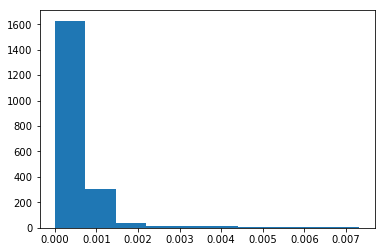

In [59]:
plt.hist(rf_estimator.named_steps["rf"].feature_importances_)

In [60]:
variable_importance =\
    pd.concat([pd.DataFrame(X_train.columns),
               pd.DataFrame(rf_estimator.named_steps["rf"].feature_importances_)], axis=1)
variable_importance.columns =["variable", "importance"]
    
variable_importance = variable_importance.sort_values(by="importance", ascending=False)
variable_importance.head(15)

,variable,importance
330,percent_0_11_diffClosing stocks(kmt),0.007323
310,percent_0_6_diffClosing stocks(kmt),0.007021
553,1_diffSumRefinery intake(kmt) nanmedian,0.006753
517,1_diffSumClosing stocks(kmt) percentile_90,0.006682
290,percent_0_1_diffClosing stocks(kmt),0.006666
523,1_diffSumExports(kmt) nanmedian,0.006631
527,1_diffSumExports(kmt) percentile_90,0.006527
522,1_diffSumExports(kmt) amax,0.006459
322,percent_0_9_diffClosing stocks(kmt),0.006432
1730,1_diffImports(kmt)_y,0.006317


# 5 - Prediction

In [63]:
id_final_test = final_test.ID

In [64]:
X_final_test = final_test.drop("ID", axis=1)

In [69]:
predictions =\
    0.4 * rf_estimator.predict_proba(X_final_test.drop(["prediction_rf", "prediction_gb"], axis=1))[:, 1] +\
    0.4 * gb_estimator.predict_proba(X_final_test.drop(["prediction_rf", "prediction_gb"], axis=1))[:, 1] +\
    0.2 * et_estimator.predict_proba(X_final_test)[:, 1]
    

In [71]:
result = pd.DataFrame(predictions).merge(pd.DataFrame(id_final_test).reset_index(drop=True), 
                                         left_index=True, right_index=True)
result.columns = ["Target", "ID"]
result = result.loc[:, ["ID", "Target"]]
result.head()

,ID,Target
0,ID10160,0.339641
1,ID10161,0.022493
2,ID10162,0.351279
3,ID10163,0.854989
4,ID10164,0.255441


In [72]:

result.to_csv(PATH_RESULT + "result.csv", index=False, sep=";", quoting=csv.QUOTE_NONNUMERIC)